In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import sys
sys.path.append('../')
from lib import *
plt.style.use('../peptidome.mplstyle')

In [2]:
proteinatlas = pd.read_csv('../../data/proteinatlas.tsv.zip', sep='\t')
tissues = [c for c in proteinatlas.columns if 'Tissue' in c]
proteinatlas[tissues] = proteinatlas[tissues].div(proteinatlas[tissues].sum(axis=0), axis=1)
proteinatlas.fillna(0, inplace=True)

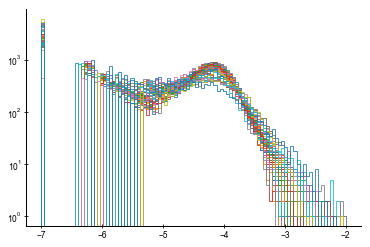

In [3]:
bins = np.linspace(-7, -2, 100)
for tissue in tissues:
    plt.hist(np.log10(1e-7+proteinatlas[tissue]), histtype='step', bins=bins)
plt.yscale('log')

In [21]:
humanproteome = load_proteome_as_df('Human')
humanproteome = humanproteome[~(humanproteome['Gene'] == '')]
humanproteome = humanproteome.set_index('Gene')
humanproteome = humanproteome.squeeze()

In [5]:
missing = set(proteinatlas['Gene'].unique()) - set(humanproteome.index)

In [6]:
proteinatlas = proteinatlas[~proteinatlas['Gene'].isin(missing)]
proteinatlas[tissues] = proteinatlas[tissues].div(proteinatlas[tissues].sum(axis=0), axis=1)

In [22]:
%timeit -t humanproteome.loc[np.random.choice(proteinatlas['Gene'], p=proteinatlas[tissues[3]])]

505 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
def generator(N, k, p):
    counter = 0
    while counter < N:
        sequence = humanproteome.loc[np.random.choice(proteinatlas['Gene'], p=p)]
        if len(sequence)>k:
            startindex = np.random.randint(0, len(sequence)-k)
            counter += 1
            yield sequence[startindex:startindex+k]

In [48]:
freqs = {}
for tissue in tissues:
    df = Counter(generator(1000, 9, np.array(proteinatlas[tissue])), 1).to_df()
    df.set_index('seq', inplace=True)
    df = df.squeeze()
    freqs[tissue] = df

In [49]:
df = Counter(proteome_path('Human'), 1).to_df()
df.set_index('seq', inplace=True)
df = df.squeeze()
freqs['All'] = df

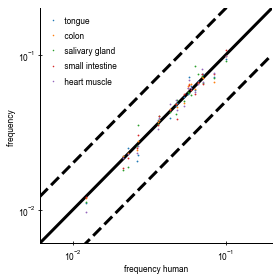

In [50]:
fig, ax = plt.subplots(figsize=(4, 4))
xmin, xmax = 0.5*np.amin(freqall), 2*np.amax(freqall)
x = np.logspace(np.log10(xmin), np.log10(xmax))
ax.plot(x, x, 'k', lw=3)
ax.plot(x, x*2, '--k', lw=3)
ax.set_xlim(xmin, xmax)
ax.set_ylim(xmin, xmax)
ax.plot(x, x/2, '--k', lw=3)
for tissue in np.random.choice(tissues, 5):
    ax.plot(freqs['All'], freqs[tissue], 'o', ms=1, label=tissue.split('-')[-1][:-5])
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency human')
ax.set_ylabel('frequency ')
fig.tight_layout()
fig.savefig('main.png')


In [52]:
pd.DataFrame(freqs).to_csv('freqs.csv', index=True)

In [53]:
np.random.choice?